## Import Statements

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score

In [2]:
df = pd.read_pickle('Combined_Social_Data_Pickle.pkl')

In [3]:
df.head(5).T

,0,1,2,3,4
Facebook,1,1,1,1,1
Instagram,0,0,0,0,0
Twitter,0,0,0,0,0
Youtube,0,0,0,0,0
age,26,26,26,26,26
artist_name_x,21Savage,21Savage,21Savage,21Savage,21Savage
artist_name_y,21 Savage,21 Savage,21 Savage,21 Savage,21 Savage
count_of_followers,NaN,NaN,NaN,NaN,NaN
created,2015-05-18 15:24:23,2015-05-25 12:00:00,2015-05-25 18:26:12,2015-08-14 12:00:00,2015-09-05 12:00:00
created_12am-6am,0,0,0,0,0


In [4]:
df.shape

(1084355, 42)

## Data Cleaning for Machine Learning

In [5]:
#Only use data from 1/1/16 to 6/1/19
df = df[(df['created']>pd.to_datetime('01-01-2016')) & (df['created']<pd.to_datetime('06-01-2019'))]

In [6]:
print(min(df.created))
print(max(df.created))

2016-01-01 00:00:01
2019-05-31 23:46:40


In [7]:
df.shape

(681571, 42)

In [8]:
#Intentionally leaving out social engagement score, genre for now.
#Omitting within_month and within_week_release since we have num_days_to_track_release
#artist_name_x will need to be removed before GMM
#NLP features should be added once available
features_to_use = ['Facebook','Instagram','Twitter','Youtube','age','artist_name_x','created_12am-6am',
                   'created_12pm-6pm','created_6am-12pm','created_6pm-12am','description_length','hashtag_count',
                   'last_30_days','last_7_days','time_since_last_post','type_link','type_photo','type_text',
                   'type_video','years_active','num_days_to_track_release']

In [9]:
df = df[features_to_use]

In [10]:
df.dropna(inplace=True)

In [11]:
df.shape

(653863, 21)

In [12]:
df['time_since_last_post'] = pd.to_timedelta(df['time_since_last_post'])
df['time_since_last_post'] = [x.total_seconds() for x in df['time_since_last_post']]

In [13]:
df.head().T

,702,703,704,705,706
Facebook,1,1,1,1,1
Instagram,0,0,0,0,0
Twitter,0,0,0,0,0
Youtube,0,0,0,0,0
age,37,37,37,37,37
artist_name_x,AdamLambert,AdamLambert,AdamLambert,AdamLambert,AdamLambert
created_12am-6am,0,0,0,0,0
created_12pm-6pm,1,1,0,1,1
created_6am-12pm,0,0,1,0,0
created_6pm-12am,0,0,0,0,0


In [14]:
df2 = df.drop(columns='artist_name_x')

## Data Standardization / Normalization

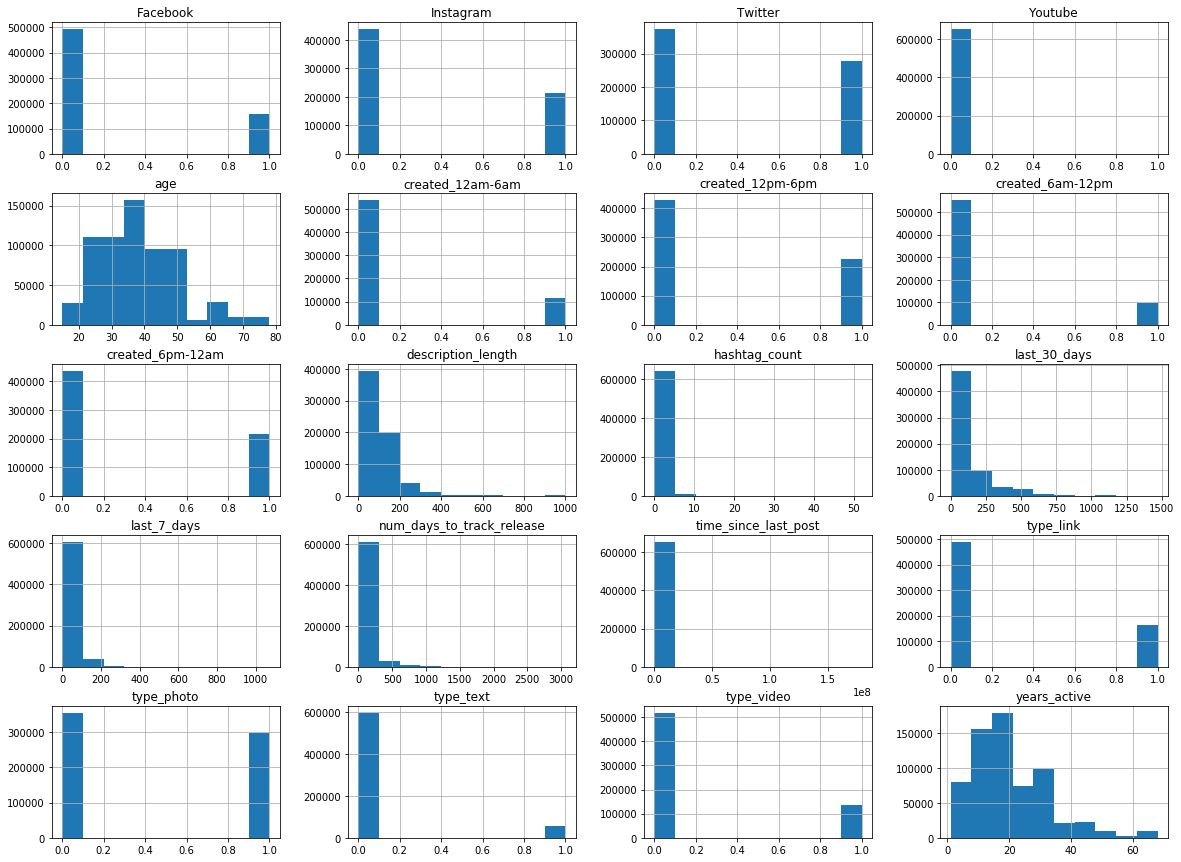

In [15]:
#Check for skew
df2.hist(figsize = (20,15))
plt.show()

In [16]:
df2.describe()

,Facebook,Instagram,Twitter,Youtube,age,created_12am-6am,created_12pm-6pm,created_6am-12pm,created_6pm-12am,description_length,hashtag_count,last_30_days,last_7_days,time_since_last_post,type_link,type_photo,type_text,type_video,years_active,num_days_to_track_release
count,653863.000000,653863.000000,653863.000000,653863.000000,653863.000000,653863.000000,653863.000000,653863.000000,653863.000000,653863.000000,653863.000000,653863.000000,653863.000000,6.538630e+05,653863.000000,653863.000000,653863.000000,653863.000000,653863.000000,653863.000000
mean,0.243611,0.327221,0.426987,0.002181,38.065011,0.175346,0.343807,0.150675,0.330172,101.073011,0.748340,132.210328,36.693368,6.780914e+04,0.250692,0.455608,0.087249,0.206452,20.159937,86.258447
std,0.429261,0.469199,0.494641,0.046649,12.031725,0.380263,0.474978,0.357732,0.470275,102.837789,1.472559,163.446778,60.554080,5.271556e+05,0.433412,0.498026,0.282200,0.404759,12.248138,183.857416
min,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,37.000000,0.000000,34.000000,9.000000,2.071000e+03,0.000000,0.000000,0.000000,0.000000,11.000000,7.000000
50%,0.000000,0.000000,0.000000,0.000000,38.000000,0.000000,0.000000,0.000000,0.000000,80.000000,0.000000,72.000000,19.000000,1.470200e+04,0.000000,0.000000,0.000000,0.000000,18.000000,24.000000
75%,0.000000,1.000000,1.000000,0.000000,45.000000,0.000000,1.000000,0.000000,1.000000,134.000000,1.000000,156.000000,42.000000,6.925000e+04,1.000000,1.000000,0.000000,0.000000,28.000000,82.000000
max,1.000000,1.000000,1.000000,1.000000,78.000000,1.000000,1.000000,1.000000,1.000000,1000.000000,52.000000,1469.000000,1070.000000,1.788741e+08,1.000000,1.000000,1.000000,1.000000,68.000000,3064.000000


In [17]:
# Most of the continuous features appear skewed right
skews = ['years_active','num_days_to_track_release','time_since_last_post','last_7_days','last_30_days',
        'hashtag_count','description_length','age']

Non-positive values can't be boxcoxed...

num_days_to_track_release

time_since_last_post

last_7_days

last_30_days

hashtag_count

In [18]:
#df2['age'], _ = boxcox(df2['age'])

In [19]:
#Necessary to use this method instead of boxcox since we have 'zero' values in many of the features and
#boxcox is only capable of working with positive values.
pt = PowerTransformer(method='yeo-johnson', standardize=False)
for skew in skews:
    df2[skew] = pt.fit_transform(np.array(df2[skew]).reshape(-1, 1))

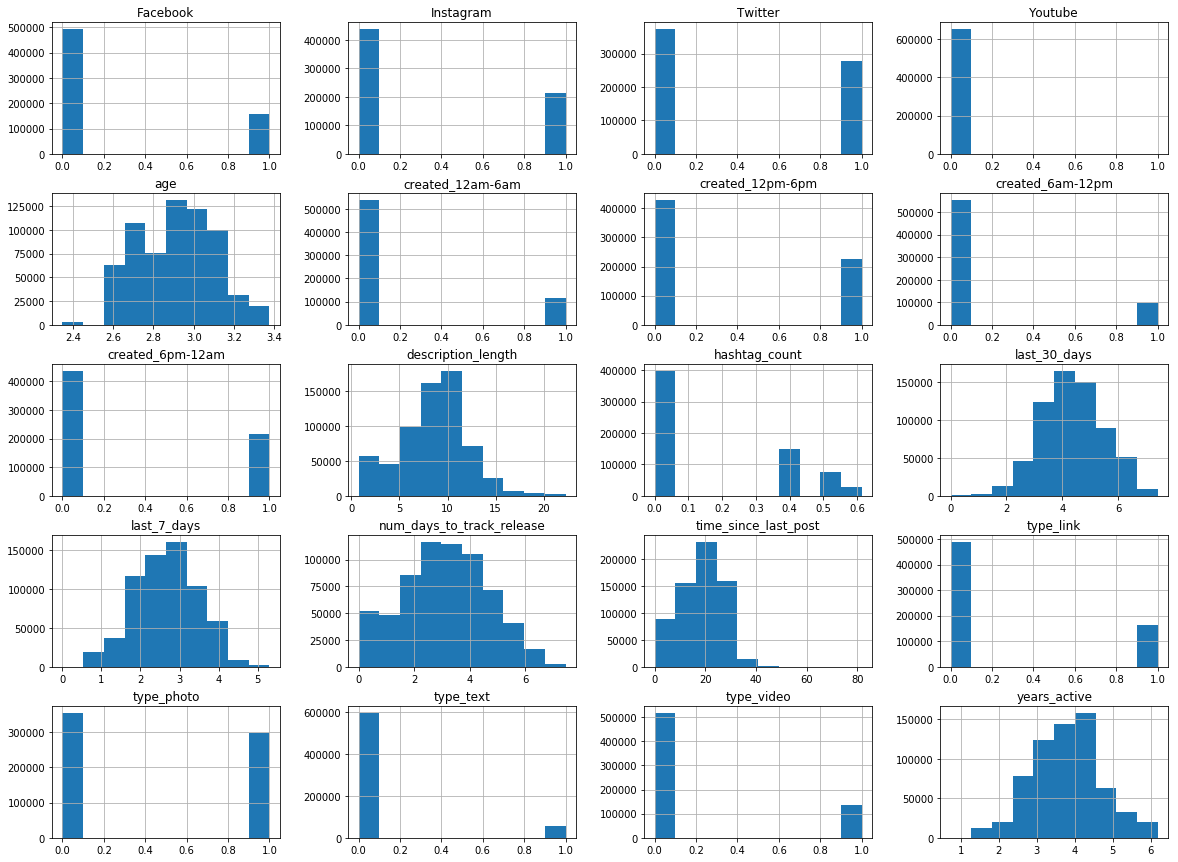

In [20]:
#Check for skew
df2.hist(figsize = (20,15))
plt.show()

In [21]:
scaler = StandardScaler()
df2_norm = scaler.fit_transform(df2)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [22]:
df2_norm.shape

(653863, 20)

## Dimensionality Reduction

### PCA

In [26]:
pca = PCA(n_components=16)
df2_norm_pca = pca.fit_transform(df2_norm)

In [60]:
# to be used for charting in 3D
pca_3d = PCA(n_components=3)
df2_norm_pca_3d = pca.fit_transform(df2_norm)

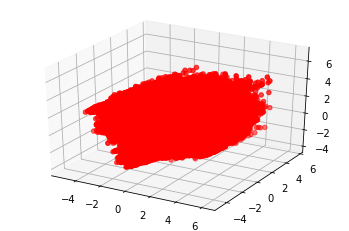

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df2_norm_pca[:, 0], df2_norm_pca[:, 1], df2_norm_pca[:, 2], c='r', marker='o')
plt.show()

array([0.16234904, 0.27158546, 0.37359921, 0.45105632, 0.52408123,
       0.59337928, 0.65850271, 0.71947903, 0.77427354, 0.82620945,
       0.87447376, 0.91557758, 0.9433799 , 0.96862232, 0.99242746,
       0.99631572, 1.        , 1.        , 1.        , 1.        ])

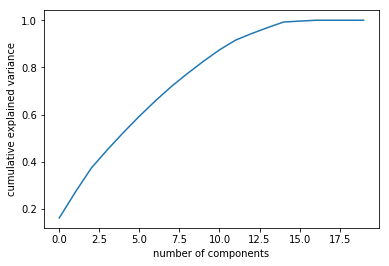

In [56]:
# Use variance ratio to understand how many components we should use
# based on PCA, we need 16 components to capture all variance
pca = PCA()
df2_norm_pca_n = pca.fit(df2_norm)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
np.cumsum(pca.explained_variance_ratio_)

### Kernel PCA

In [23]:
# # this kills the kernel everytime
# from sklearn.decomposition import KernelPCA
# kpca = KernelPCA(n_components=3, kernel="poly")
# df2_norm_kpca = kpca.fit_transform(df2_norm)

### t-SNE (with PCA initialization)

In [ ]:
# %%time
# # we can also adjust perplexity, learning rate, and number of iterations
# tsne = TSNE(n_components=3, random_state=0)  
# df2_norm_tsne = tsne.fit_transform(df2_norm_pca)

In [ ]:
# plt.scatter(df2_norm_tsne[:, 0], df2_norm_tsne[:, 1])
# plt.axis('equal')

## GMM Modeling

In [91]:
# function to run GMM with given dataset & automatically choose best k
# prints distribution of posts across clusters
def run_gmm(dataset):
    best_score = -np.inf
    best_k = None
    best_model = None
    best_cluster_assignments = None

    for k in range(4, 11):
        candidate_gmm = GaussianMixture(n_components=k, n_init=1, random_state=0)
        candidate_gmm.fit(dataset)
        cluster_assignments = candidate_gmm.predict(dataset)
        sil_score = silhouette_score(dataset, cluster_assignments)
        ch_score = calinski_harabaz_score(drug_data_normalized_tsne2d, cluster_assignments)

        print('k =', k, 'has CH score', calinski_harabaz_score, 'and silhouette score', sil_score)

        score = sil_score # change this if want to use CH score instead
        if score > best_score:
            best_score = score
            best_k = k
            best_model = candidate_gmm
            best_cluster_assignments = cluster_assignments

    print('Best k according to Silhouette Score:', best_k)

    gmm_cluster_assignments = best_model.predict(dataset)
    
    # print breakdown of posts by gmm cluster assignment
    print('Distribution of posts by cluster:')
    y = np.bincount(gmm_cluster_assignments)
    ii = np.nonzero(y)[0]
    cluster_distribution = pd.DataFrame(np.vstack((ii,y[ii])).T, columns = ['Cluster', 'Count of Posts'])
    print(cluster_distribution)
    
    return gmm_cluster_assignments

In [ ]:
# run GMM with 3 Components for visualization
gmm_3d = run_gmm(df2_norm_pca_3d)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df2_norm_pca_3d[:, 0], df2_norm_pca_3d[:, 1], df2_norm_pca_3d[:, 2], c=gmm_3d, cmap='Spectral')
plt.show()

In [ ]:
# run GMM with 16 Components for analysis
gmm_nd = run_gmm(df2_norm_pca)